# Bibliotecas requeridas

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
import cv2
import pandas as pd
import random
import os
import ntpath
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
from imgaug import augmenters as iaa


# Carga y analisis de la data

### Copiar de github

In [80]:
# Copiar la data del repositorio de github y almacenarla en un df.
#!git clone https://github.com/AndreGutierrezTecMx/NavAutonoma
data_dir = 'Train_data_navegacion_autonoma/'
df = pd.read_csv(os.path.join(data_dir, 'data.csv'))
df.head()

,path_img_right,path_img_left,path_img_front,angle,steering_angle
0,Train_data_navegacion_autonoma\images\right_im...,Train_data_navegacion_autonoma\images\left_ima...,Train_data_navegacion_autonoma\images\front_im...,-0.176,-0.176
1,Train_data_navegacion_autonoma\images\right_im...,Train_data_navegacion_autonoma\images\left_ima...,Train_data_navegacion_autonoma\images\front_im...,-0.176,-0.176
2,Train_data_navegacion_autonoma\images\right_im...,Train_data_navegacion_autonoma\images\left_ima...,Train_data_navegacion_autonoma\images\front_im...,-0.176,-0.176
3,Train_data_navegacion_autonoma\images\right_im...,Train_data_navegacion_autonoma\images\left_ima...,Train_data_navegacion_autonoma\images\front_im...,-0.176,-0.176
4,Train_data_navegacion_autonoma\images\right_im...,Train_data_navegacion_autonoma\images\left_ima...,Train_data_navegacion_autonoma\images\front_im...,-0.176,-0.176


In [81]:
# Obten unicamente el nombre de la imagen en lugar de la ruta completa.
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

df['path_img_front'] = df['path_img_front'].apply(path_leaf)
df['path_img_left'] = df['path_img_left'].apply(path_leaf)
df['path_img_right'] = df['path_img_right'].apply(path_leaf)
df.head()
angle_name = 'steering_angle'

### Analizar la organización de la data

Hacemos un histograma con el siguiente código para saber que tan balanceada esta nuestra data. En caso de tener data muy desvalanceada (muchas rectas y pocos giros) podemos agregar o quitar data.

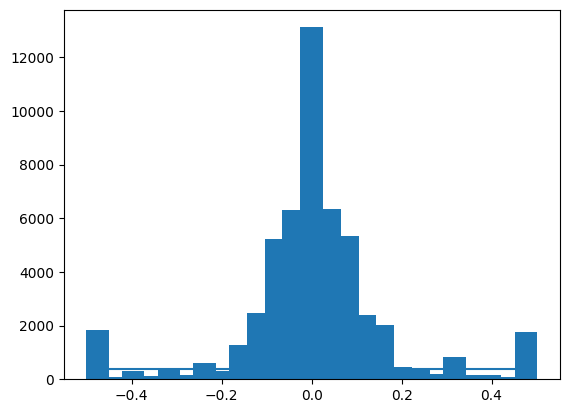

In [82]:
num_bins = 25

samples_per_bin = 400

hist, bins = np.histogram(df[angle_name], num_bins)
center = (bins[:-1]+ bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(df[angle_name]), np.max(df[angle_name])), (samples_per_bin, samples_per_bin))

Por lo analizado del histograma anterior decidimos no añadir o quitar data.

### Dividir imagenes y angulos de giro

In [83]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        right, left, front = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, front.strip()))
        steering.append(float(indexed_data[3]))
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering(data_dir + '/images', df)
print (image_paths.shape)
print (steerings.shape)

C:\Users\andre\AppData\Local\Temp\ipykernel_7924\745628139.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  right, left, front = indexed_data[0], indexed_data[1], indexed_data[2]
C:\Users\andre\AppData\Local\Temp\ipykernel_7924\745628139.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[3]))
C:\Users\andre\AppData\Local\Temp\ipykernel_7924\745628139.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc

(156756,)
(156756,)


### Dividir data de entrenamiento y validacion

In [84]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 125404
Valid Samples: 31352


Text(0.5, 1.0, 'Validation set')

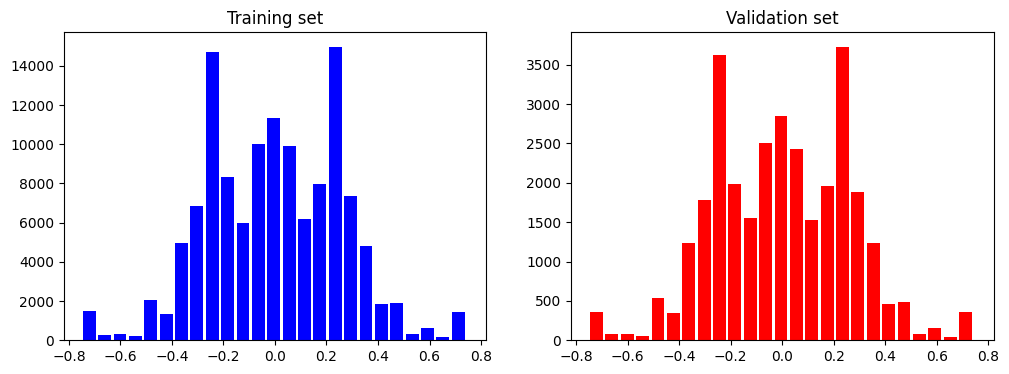

In [85]:
# Comprobamos la distribución de la data.
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

# Procesamiento de las imágenes

### Definición de métodos de procesamiento de imágen

In [86]:
# Función para hacer zoom a la imágen.
def zoom(image):
  zoom = iaa.Affine(scale=(1, 1.1))
  image = zoom.augment_image(image)
  return image

# Función para hacer la imágen panorámica.
def pan(image):
  pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

# Función para girar las imagenes y volver contrario el ángulo.
def img_random_flip(image, steering_angle):
  image = cv2.flip(image,1)
  steering_angle = -steering_angle
  return image, steering_angle

# Función para preprocesar la imagen
def img_preprocess(img):
  # Recortar la parte superior y lateral de la imagen
  img = img[35:60, 0:60]
  # Escalar la imagen a 200x66
  img = cv2.resize(img, (200, 66))
  # Transformar el color
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  # Aplicar desenfoque Gaussiano
  img = cv2.GaussianBlur(img, (3, 3), 0)
  return img

# Aplicar las transformaciónes aleatoriamente.
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_flip(image, steering_angle)
  return img_preprocess(image), steering_angle

### Comprobación de procesamiento de imagenes

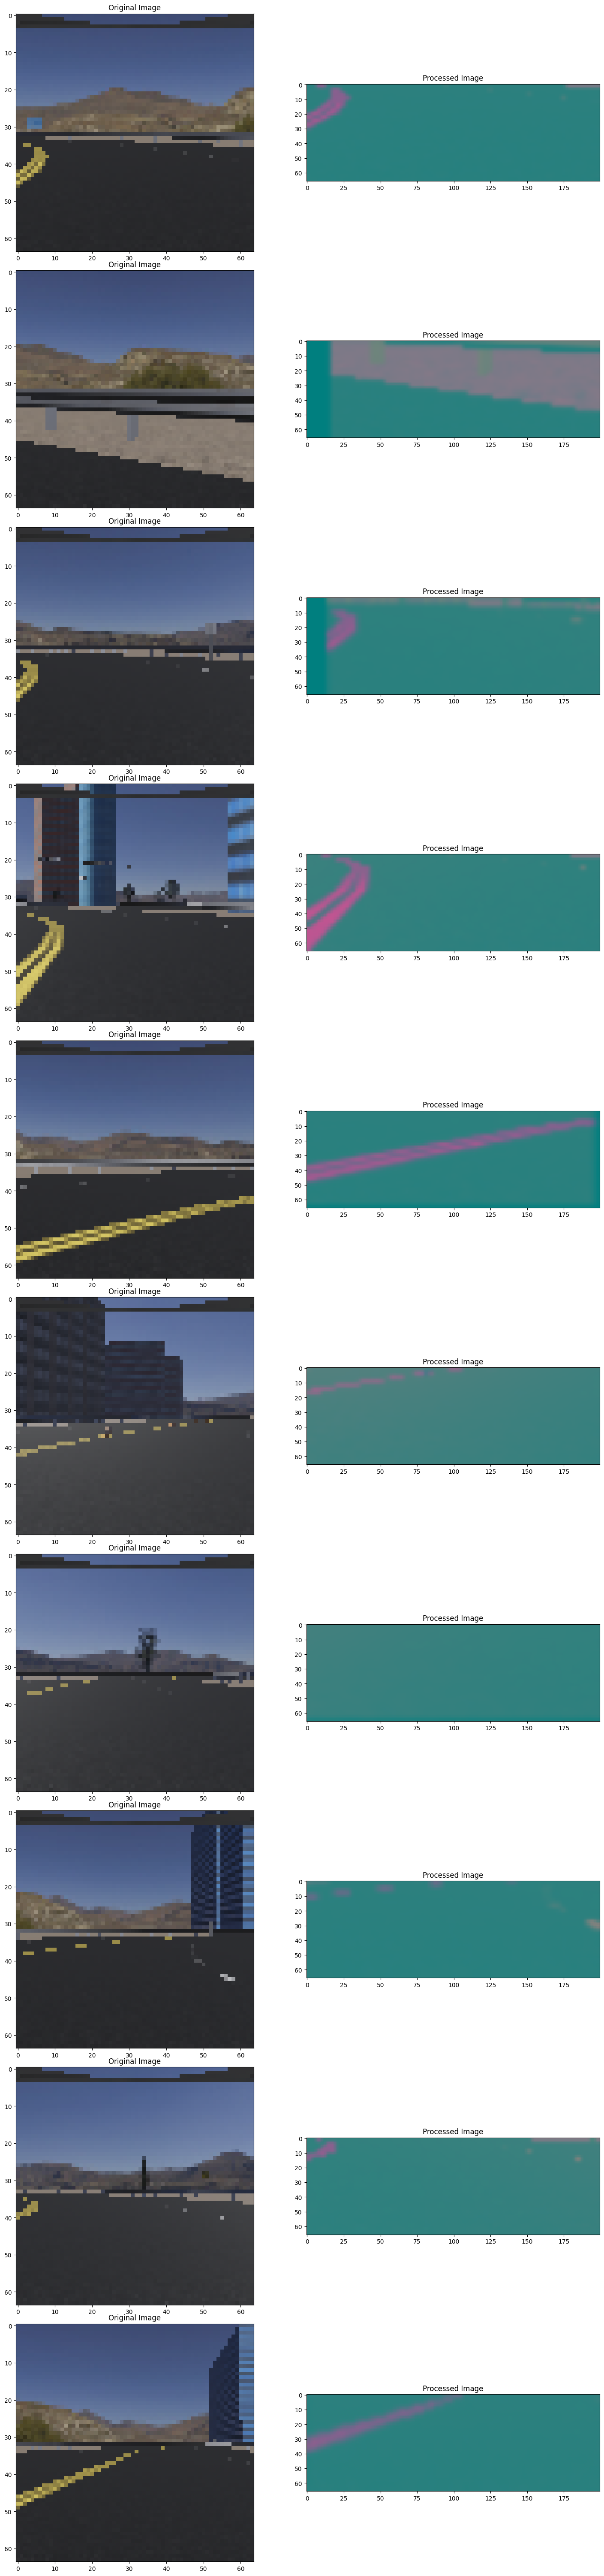

In [87]:
ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 60))
fig.tight_layout()

for i in range(nrow):
    randnum = random.randint(0, len(X_valid) - 1)
    random_image = X_valid[randnum]

    original_image = mpimg.imread(random_image)
    processed_image, steering = random_augment(random_image, steerings[randnum])

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(processed_image)
    axs[i][1].set_title("Processed Image")

# Entrenamiento del modelo

### Creación de un generador de datos

In [ ]:
# batch generator.
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    batch_img = []
    batch_steering = []

    for i in range(batch_size):

        random_index = random.randint(0, len(image_paths) - 1)

        if istraining:
            im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
        else:
            im = mpimg.imread(image_paths[random_index])
            im = img_preprocess(im)
            steering = steering_ang[random_index]

        batch_img.append(im)
        batch_steering.append(steering)
    yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

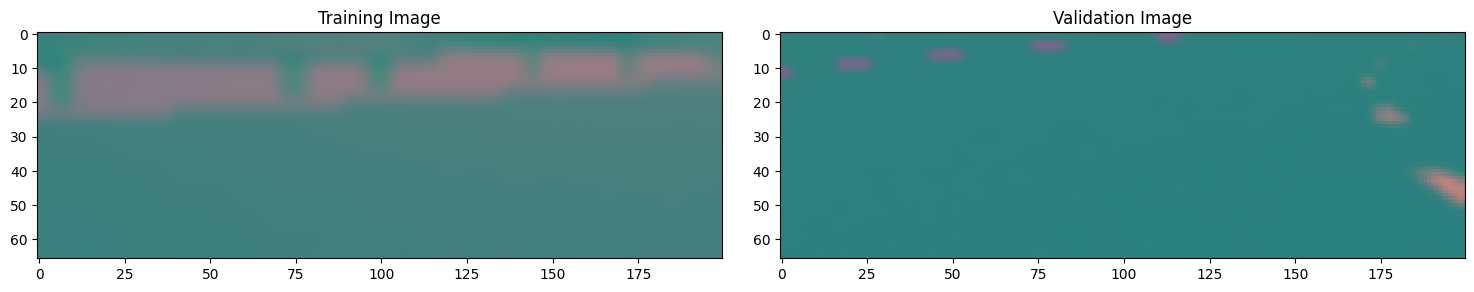

In [88]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

### Creación del modelo

In [89]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Conv2D(64, (3, 3), activation='elu'))
    model.add(Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(100, activation = 'elu'))

    model.add(Dense(50, activation = 'elu'))


    model.add(Dense(10, activation = 'elu'))


    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [90]:
model = nvidia_model()
print(model.summary())

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 31, 98, 24)     │         1,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 14, 47, 36)     │        21,636 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 5, 22, 48)      │        43,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 3, 20, 64)      │        27,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 1, 18, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 18, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 100)            │       115,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 10)             │           510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,219 (985.23 KB)

 Trainable params: 252,219 (985.23 KB)

 Non-trainable params: 0 (0.00 B)

None


### Entrenamiento del modelo

In [91]:
history = model.fit(batch_generator(X_train, y_train, 300, 1),
                    steps_per_epoch=300,
                    epochs=10,
                    validation_data=batch_generator(X_valid, y_valid, 300, 0),
                    validation_steps=200,
                    verbose=1,
                    shuffle = 1)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 206s 681ms/step - loss: 0.2275 - val_loss: 0.0517
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 185s 618ms/step - loss: 0.0538 - val_loss: 0.0439
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 181s 605ms/step - loss: 0.0485 - val_loss: 0.0435
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 181s 605ms/step - loss: 0.0470 - val_loss: 0.0426
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 184s 615ms/step - loss: 0.0459 - val_loss: 0.0417
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 196s 656ms/step - loss: 0.0459 - val_loss: 0.0407
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 200s 668ms/step - loss: 0.0445 - val_loss: 0.0388
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 191s 640ms/step - loss: 0.0442 - val_loss: 0.0400
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 189s 632ms/step - loss: 0.0438 - val_loss: 0.0385
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 191s 637ms/step - loss: 0.0424 - val_loss: 0.0379


Text(0.5, 0, 'Epoch')

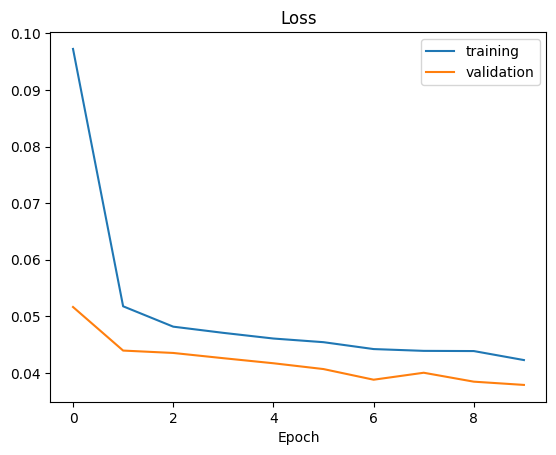

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [94]:
im = mpimg.imread(image_paths[50])
im = img_preprocess(im)
im = np.expand_dims(im, axis=0) 
print(f"Prediccion: {model.predict(im)}. Real: {steerings[50]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Prediccion: [[-0.24958551]]. Real: -0.426


### Guardar el modelo

In [93]:
model.save('nvidia_model_5.keras')